# Exploring Relations between SNAP benefits and Health Insurance

## Data Preparation

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 

### SNAP State Rates

In [2]:
!wget https://raw.githubusercontent.com/michaelbbryan/tools-and-kaggles/main/DataDive2022/snapmergecounty.csv

--2023-01-09 13:06:43--  https://raw.githubusercontent.com/michaelbbryan/tools-and-kaggles/main/DataDive2022/snapmergecounty.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21481417 (20M) [text/plain]
Saving to: 'snapmergecounty.csv'

snapmergecounty.csv 100%[===================>]  20.49M  31.4MB/s    in 0.7s    

2023-01-09 13:06:44 (31.4 MB/s) - 'snapmergecounty.csv' saved [21481417/21481417]



In [3]:
snap_county = pd.read_csv("snapmergecounty.csv", dtype={"countyFIPS":"str", "stateFIPS":"str"})

In [28]:
totpersonsstate =  snap_county.groupby(['stateNAME', 'year'])['PersonsTotal'].sum()

In [4]:
snap_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183005 entries, 0 to 183004
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Substate                       183005 non-null  object 
 1   PersonsPublic                  183005 non-null  float64
 2   PersonsNonPublic               183005 non-null  float64
 3   PersonsTotal                   183005 non-null  float64
 4   HouseholdsPublicAssistance     183005 non-null  float64
 5   HouseholdsNonPublicAssistance  183005 non-null  float64
 6   HouseholdsTotal                183005 non-null  float64
 7   Issuance                       183005 non-null  float64
 8   month                          183005 non-null  object 
 9   year                           183005 non-null  int64  
 10  countyFIPS                     183005 non-null  object 
 11  countyNAME                     183005 non-null  object 
 12  stateFIPS                     

In [4]:
snap_county_selection = snap_county[snap_county["year"].isin(["2015", "2016", "2017", "2018", "2019", "2020"])]
snap_county_selection = snap_county[snap_county["month"]=="JUL"]

### ACS Tables

In [103]:
mergelist = []
for chunk in ['1','2','3','4','5']:
    part = pd.read_csv('/Users/kaylawilding/Documents/GitHub/BDT_DataDive_Dec22/data-sources/acsmerged/acsmerge'+chunk+'.csv')
    part['countyFIPS'] = part['countyFIPS'].astype(str).str.zfill(5)
    part['year'] = part['year'].astype(str)
    part['NAME'] = part['NAME'].astype(str)
    part['GEO_ID'] = part['GEO_ID'].astype(str)
    for col in [c for c in part.columns if c not in ['GEO_ID', 'NAME', 'countyFIPS', 'year']]:
        part[col] = part[col].astype(float)
    mergelist.append(part)
acs_merge = pd.concat(mergelist, axis=0, ignore_index=True)

In [104]:
acs_merge.to_csv('/Users/kaylawilding/Documents/GitHub/BDT_DataDive_Dec22/data-sources/acsmerged/acsmerge.csv')

In [ ]:
#acs_merge = pd.read_csv("acsmerge.csv", low_memory=False, dtype={"countyFIPS":"str"})

In [9]:
acs_meta = pd.read_csv('./BDT_DataDive_Dec22/data-sources/acsmerged/acsmetadata.csv')

In [8]:
acs_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2842 entries, 0 to 2841
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         2842 non-null   object
 1   Column Name        1979 non-null   object
 2   Label              1979 non-null   object
 3   Table Name         1979 non-null   object
 4   Table Description  1979 non-null   object
dtypes: object(5)
memory usage: 111.1+ KB


In [10]:
# Get FIPS reference data
fipsstate = pd.read_fwf('https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt',
                        skiprows=16, skipfooter=3198, dtype=str,
                        names=['stateFIPS','stateNAME'], colspecs = [(7, 9), (17, 30)])
fipscounty = pd.read_fwf('https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt',
                        skiprows=72, dtype=str,
                        names=['countyFIPS','countyNAME'], colspecs = [(4, 9), (17, 80)])
fipscounty['stateFIPS'] = fipscounty.countyFIPS.str[:2]
fips = pd.merge(fipscounty,fipsstate,on='stateFIPS',how='left')

In [11]:
# Add state info
acs_state = pd.merge(acs_merge, fips, on="countyFIPS", how="left")

In [12]:
acs_state["stateNAME"] = acs_state["stateNAME"].str.title()

In [22]:
acs_state['year'] = pd.to_numeric(acs_state['year'])

### Merge datasets

In [23]:
snap_acs = pd.merge(acs_state, snap_county_selection, on=["year","countyFIPS"])

## Exploring relationships

In [24]:
BDT_states = ["Colorado", "Maryland", "Michigan", "New York", "North Carolina", "Pennsylvania",  "South Carolina"] 
additional_states = ["Alabama", "Florida", "Louisiana", "Mississippi", "Oklahoma", "Texas", "Tennessee"]

def BDT_identifier(w):
    if w in BDT_states:
        return 1
    elif w in additional_states:
        return 2
    else:
        return 0  

acs_state["BDT_states"] = acs_state["stateNAME"].apply(BDT_identifier)


/var/folders/cd/yhbft8yj611dsg2rkjqhhsv00000gn/T/ipykernel_10344/1035396036.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  acs_state["BDT_states"] = acs_state["stateNAME"].apply(BDT_identifier)


In [25]:
snap_acs["BDT_states"] = snap_acs["stateNAME_x"].apply(BDT_identifier)

/var/folders/cd/yhbft8yj611dsg2rkjqhhsv00000gn/T/ipykernel_10344/1700558143.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  snap_acs["BDT_states"] = snap_acs["stateNAME_x"].apply(BDT_identifier)


### All population

Useful variables names and meaning (Pulled from BDT_DataDive_Dec22/data-sources/acsmerged/acsmetadata.csv)
- #S2701_C02_001E = Estimate!!Insured!!Civilian noninstitutionalized population
- #S2701_C03_001E	Estimate!!Percent Insured!!Civilian noninstitutionalized population
- #S2701_C01_001E	Estimate!!Total!!Civilian noninstitutionalized population
- #S2701_C01_058E	Estimate!!Total!!Civilian noninstitutionalized population!!RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS!!Civilian noninstitutionalized population for whom      poverty status is determined!!Below 138 percent of the poverty threshold
- #S2701_C04_001E	Estimate!!Uninsured!!Civilian noninstitutionalized population
- #S2701_C05_001E	Estimate!!Percent Uninsured!!Civilian noninstitutionalized population
- #S2701_C05_058E	Estimate!!Percent Uninsured!!Civilian noninstitutionalized population!!RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS!!Civilian noninstitutionalized population - for whom poverty status is determined!!Below 138 percent of the poverty threshold
- #S2701_C04_058E	Estimate!!Uninsured!!Civilian noninstitutionalized population!!RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 12 MONTHS!!Civilian noninstitutionalized population for whom poverty status is determined!!Below 138 percent of the poverty threshold


In [69]:
health_subset = snap_acs[['year', 'stateNAME_x', 'S2701_C02_001E', 'PersonsTotal','S2701_C01_001E','S2701_C01_058E', 'S2701_C04_001E', 'S2701_C04_058E']]
#health_subset_19 = health_subset[health_subset.year==2019]
health_year_st = health_subset.groupby(['year', 'stateNAME_x'], as_index=False).sum()
health_year_st["BDT_states"] = health_year_st["stateNAME_x"].apply(BDT_identifier)


In [97]:
health_year_st['percent_uninsured'] = health_year_st['S2701_C04_001E']/health_year_st['S2701_C01_001E']
health_year_st['percent_uninsured_eligble'] = health_year_st['S2701_C04_058E']/health_year_st['S2701_C01_058E']
health_year_st['percent_snap'] = health_year_st['PersonsTotal']/health_year_st['S2701_C01_001E']
health_year_st['percent_snap_eligible'] = health_year_st['PersonsTotal']/health_year_st['S2701_C01_058E']
health_year_st['snap_gap'] = 1 - health_year_st['percent_snap_eligible']
health_year_st = health_year_st[health_year_st['percent_snap_eligible'] < 1]

## Population: SNAP Eligible Proxy (Income < 138% of poverty threshold)

### Correlation: Uninsured vs. SNAP Enrollment

#### 2015-2020

Text(0.5, 0, 'Percent not-receiving SNAP')

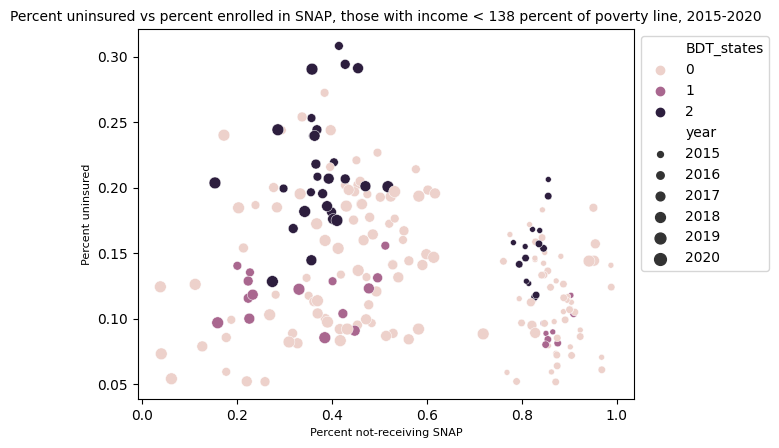

In [102]:
#Of those eligible (where eligibility is proxied by income <138 percent of poverty line as this is the closest breakdown in the data to the SNAP eligibility of gross income is 130 percent),
#looking at the percent uninsured vs the percent that do not receive SNAP, ie. are not enrolled. 
plot= sns.scatterplot(data=health_year_st, x="snap_gap", 
                y="percent_uninsured_eligble", hue="BDT_states", size = 'year')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plt.title("Percent uninsured vs percent enrolled in SNAP, those with income < 138 percent of poverty line, 2015-2020", fontsize=10)
plt.ylabel("Percent uninsured", fontsize=8)
plt.xlabel("Percent not-receiving SNAP", fontsize=8)

### Public health Insurance and Medicaid

Possibly Useful tables/variables: 
- S2704:
    - S2704_C03_026E,Estimate!!Percent Public Coverage!!COVERAGE ALONE!!Public health insurance alone,S2704,PUBLIC HEALTH INSURANCE COVERAGE
    - S2704_C03_028E,Estimate!!Percent Public Coverage!!COVERAGE ALONE!!Public health insurance alone!!Medicaid/means tested coverage alone,S2704,PUBLIC HEALTH INSURANCE COVERAGE
    - S2704_C03_014E,Estimate!!Percent Public Coverage!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Below 138 percent of the poverty threshold,S2704,PUBLIC HEALTH INSURANCE COVERAGE
    - S2704_C01_001E,Estimate!!Total!!Civilian noninstitutionalized population,S2704,PUBLIC HEALTH INSURANCE COVERAGE
- C27007:
    - C27007_001E,Estimate!!Total:,C27007,MEDICAID/MEANS-TESTED PUBLIC COVERAGE
    